In [83]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import time

In [84]:
def f(x, y):
    return x + y

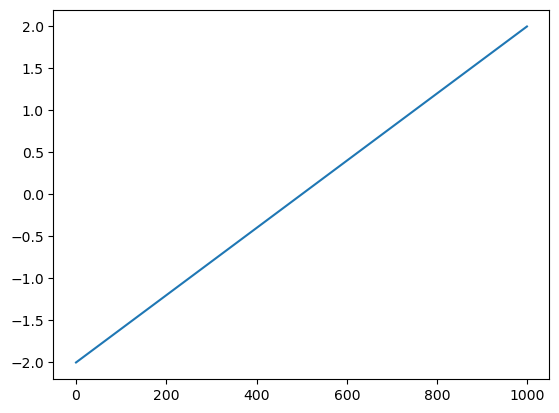

In [85]:
# Create a tensor with 1000 points between -10 and 10
x = torch.linspace(-1, 1, 1000)
y = torch.linspace(-1, 1, 1000)

# Apply the function to each point
z = f(x, y)

# Plot the result
plt.plot(z)
plt.show()

In [86]:
num_intervals = 5
spline_order = 2
region = [-1, 1]
num_control_points = num_intervals + spline_order
variance = 0.1

grid_points1 = torch.linspace(region[0], region[1], num_intervals + 1)
ext_grid_points1 = torch.cat((torch.arange(region[0] - spline_order, region[0]), grid_points1, torch.arange(region[1] + 1, region[1] + spline_order + 1)))
control_points1 = torch.as_tensor(np.random.normal(0, variance, num_control_points))

grid_points2 = torch.linspace(region[0], region[1], num_intervals + 1)
ext_grid_points2 = torch.cat((torch.arange(region[0] - spline_order, region[0]), grid_points2, torch.arange(region[1] + 1, region[1] + spline_order + 1)))
control_points2 = torch.as_tensor(np.random.normal(0, variance, num_control_points))

In [87]:
def vect_cox_de_boor(ext_grid_points, i, degree, times):
    if degree == 0:
        return (ext_grid_points[i] <= times) * (times < ext_grid_points[i + 1])
    
    left_side = (times - ext_grid_points[i]) / (ext_grid_points[i + degree] - ext_grid_points[i]) * vect_cox_de_boor(ext_grid_points, i, degree - 1, times)
    right_side = (ext_grid_points[i + degree + 1] - times) / (ext_grid_points[i + degree + 1] - ext_grid_points[i + 1]) * vect_cox_de_boor(ext_grid_points, i + 1, degree - 1, times)

    return left_side + right_side

def vect_evaluate_spline(control_points, ext_grid_points, degree, times):
    result = 0.0
    for i in range(num_intervals + degree):
        result += control_points[i] * vect_cox_de_boor(ext_grid_points, i, degree, times)
        
    return result

In [88]:
# Optimize control points to match f(x)
control_points1.requires_grad = True
control_points2.requires_grad = True
opt = torch.optim.Adam([control_points1, control_points2], lr=0.01)
# opt = torch.optim.LBFGS([control_points], lr=100)

xs1 = torch.linspace(region[0], region[1], 1000)
xs2 = torch.linspace(region[0], region[1], 1000)

for i in range(1):
    opt.zero_grad()


    app = vect_evaluate_spline(control_points1, ext_grid_points1, spline_order, xs1) + vect_evaluate_spline(control_points2, ext_grid_points2, spline_order, xs2)
    loss = (app - f(xs1, xs2))**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

Epoch 0, loss: 1.5568935871124268


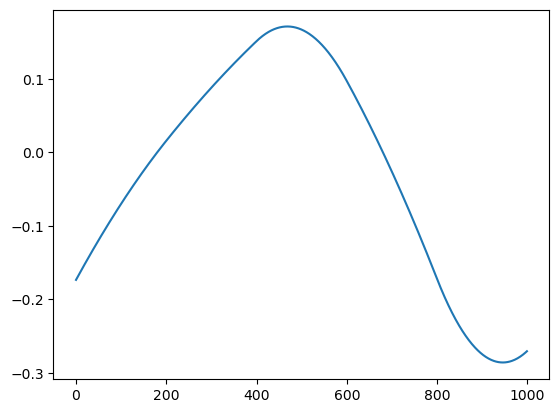

In [89]:
# Create a tensor with 1000 points between -10 and 10
x = torch.linspace(-1, 1, 1000)
y = torch.linspace(-1, 1, 1000)

# Apply the function to each point
z = vect_evaluate_spline(control_points1, ext_grid_points1, spline_order, x) + vect_evaluate_spline(control_points2, ext_grid_points2, spline_order, y)

# Plot the result
plt.plot(z.detach().numpy())
plt.show()

In [90]:
def batched_cox_de_boor(ext_grid_points, i, degree, times):
    if degree == 0:
        return (ext_grid_points[:, i] <= times) * (times < ext_grid_points[:, i + 1])
    
    left_side = (times - ext_grid_points[:, i]) / (ext_grid_points[:, i + degree] - ext_grid_points[:, i]) * batched_cox_de_boor(ext_grid_points, i, degree - 1, times)
    right_side = (ext_grid_points[:, i + degree + 1] - times) / (ext_grid_points[:, i + degree + 1] - ext_grid_points[:, i + 1]) * batched_cox_de_boor(ext_grid_points, i + 1, degree - 1, times)

    return left_side + right_side

def batched_evaluate_spline(control_points, ext_grids, degree, times):
    result = 0.0
    for i in range(num_intervals + degree):
        result += control_points[:, i] * batched_cox_de_boor(ext_grids, i, degree, times)
    
    return result.sum(dim=1)

In [91]:
batched_control_points = torch.as_tensor(np.random.normal(0, variance, (2, num_control_points)))
batched_grids = torch.stack([ext_grid_points1, ext_grid_points2])

# Optimize control points to match f(x)
batched_control_points.requires_grad = True
opt = torch.optim.Adam([batched_control_points], lr=0.01)
# opt = torch.optim.LBFGS([control_points], lr=100)

xs1 = torch.linspace(region[0], region[1], 1000)
xs2 = torch.linspace(region[0], region[1], 1000)

data = torch.stack([xs1, xs2], dim=1)

for i in range(1000):
    opt.zero_grad()

    app = batched_evaluate_spline(batched_control_points, batched_grids, spline_order, data)
    
    loss = (app - f(xs1, xs2))**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

Epoch 0, loss: 1.5225432995662451


Epoch 100, loss: 0.06339161007438256
Epoch 200, loss: 0.0029962649196404517
Epoch 300, loss: 0.001299074916548303
Epoch 400, loss: 0.0008879089981035774
Epoch 500, loss: 0.0005715661042194868
Epoch 600, loss: 0.00034612117570052495
Epoch 700, loss: 0.00019733261984976457
Epoch 800, loss: 0.00010591551204212148
Epoch 900, loss: 5.348475591733354e-05


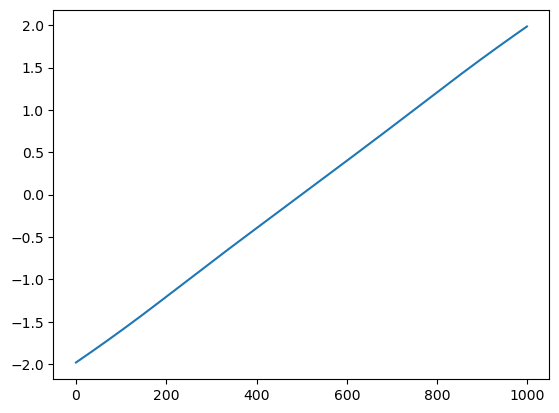

In [93]:
# Create a tensor with 1000 points between -10 and 10
x = torch.linspace(-1, 1, 1000)
y = torch.linspace(-1, 1, 1000)

data = torch.stack([x, y], dim=1)

# Apply the function to each point
z = batched_evaluate_spline(batched_control_points, batched_grids, spline_order, data)

# Plot the result
plt.plot(z.detach().numpy())
plt.show()